In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Load the dataset
df = pd.read_csv('Kenya Protests June 2025.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (49823, 179)

First few rows:


,Query Id,Query Name,Date,Title,Url,Domain,Sentiment,Page Type,Language,Country Code,...,Tiktok Shares,Tiktok Views,Weblog Title,Youtube Comments,Youtube Duration Milliseconds,Youtube Favourites,Youtube Likes,Youtube Subscriber Count,Youtube Video Count,Emotion
0,2003594270,Kenya protests 2025,2025-08-31 21:59:50.0,RT @_James041 Aden Duale is as guilty as F.\n\...,http://twitter.com/kelvinngari62/statuses/1962...,twitter.com,negative,twitter,en,KEN,...,NaN,NaN,kelvinngari62 (knn),NaN,NaN,NaN,NaN,NaN,NaN,Sadness
1,2003594270,Kenya protests 2025,2025-08-31 21:34:56.0,RT @_James041 This was during the burial of Ti...,http://twitter.com/pmwww_/statuses/19622678906...,twitter.com,negative,twitter,en,KEN,...,NaN,NaN,pmwww_ (♡),NaN,NaN,NaN,NaN,NaN,NaN,Disgust
2,2003594270,Kenya protests 2025,2025-08-31 21:21:30.0,"RT @_James041 I walked from morgue to morgue, ...",http://twitter.com/kivaya_sally/statuses/19622...,twitter.com,negative,twitter,en,KEN,...,NaN,NaN,kivaya_sally (Muhonja Biko),NaN,NaN,NaN,NaN,NaN,NaN,Sadness
3,2003594270,Kenya protests 2025,2025-08-31 21:10:49.0,Ruto Must Go!\n\n#RutoMustGo \n#FreeOurShujaa\...,http://twitter.com/Mzalend0Halisi/statuses/196...,twitter.com,neutral,twitter,en,KEN,...,NaN,NaN,Mzalend0Halisi (Karanja_MzalendoHalisi),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003594270,Kenya protests 2025,2025-08-31 20:55:23.0,RT @_James041 This was during the burial of Ti...,http://twitter.com/DaktariSiki/statuses/196225...,twitter.com,negative,twitter,en,KEN,...,NaN,NaN,DaktariSiki (Møșẽšé),NaN,NaN,NaN,NaN,NaN,NaN,Disgust


In [3]:
# Data exploration
print("Basic info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49823 entries, 0 to 49822
Columns: 179 entries, Query Id to Emotion
dtypes: bool(13), float64(88), int64(29), object(49)
memory usage: 63.7+ MB
None

Missing values:
Query Id                        0
Query Name                      0
Date                            0
Title                           0
Url                             0
                            ...  
Youtube Favourites          49823
Youtube Likes               49823
Youtube Subscriber Count    49823
Youtube Video Count         49823
Emotion                     24622
Length: 179, dtype: int64


In [10]:
# Create an edge list: from 'Thread Author' (or Thread Author field) -> each mentioned author.
# Also create edges for reposts/retweets

def extract_authors(cell):
    if pd.isna(cell) or str(cell).strip() == "":
        return []
    text = str(cell)
    parts = [p.strip() for p in re.split(r'[;,|\t\n]', text) if p.strip()]
    return parts

import re
edges = []  

for idx, row in df.iterrows():
    # source: try several candidate columns
    source = None
    for cand in ['Thread Author','Author','X Author ID','Thread Author','Full Name','Author Name','Author Display Name']:
        if cand in df.columns and pd.notna(row.get(cand)) and str(row.get(cand)).strip() != "":
            source = str(row.get(cand)).strip()
            break
    if source is None:
        continue

    # Mention edges
    if 'Mentioned Authors' in df.columns and pd.notna(row.get('Mentioned Authors')):
        targets = extract_authors(row.get('Mentioned Authors'))
        for t in targets:
            edges.append((source, t, 1, 'mention'))

    # Retweet / repost edges: if 'Repost of' or 'X Repost of' or 'Reposts' url present
    for cand in ['Repost of','X Repost of','Repost','Reposted From','Repost of (id)','Reposts']:
        if cand in df.columns and pd.notna(row.get(cand)) and str(row.get(cand)).strip() != "":
            targets = extract_authors(row.get(cand))
            for t in targets:
                edges.append((source, t, 2, 'repost'))  # give higher weight to repost edge

# If no mention or repost columns exist, try to use 'Original Url' or 'Thread URL' fields to infer retweet relationships 
print("Built edges:", len(edges))


Built edges: 54854


In [ ]:
# Build directed multigraph collapsed to weighted DiGraph
G = nx.DiGraph()
for src, tgt, w, et in edges:
    if src == tgt or src is None or tgt is None:
        continue
    if G.has_edge(src, tgt):
        G[src][tgt]['weight'] += w
    else:
        G.add_edge(src, tgt, weight=w, types={et})

# Ensure nodes include authors that posted without mentions (so we can see centrality)
all_authors = set()
for cand in ['Thread Author','Author','X Author ID','Full Name']:
    if cand in df.columns:
        all_authors.update([str(x).strip() for x in df[cand].dropna().astype(str)])
for a in all_authors:
    if a and a not in G:
        G.add_node(a)

print("Graph nodes:", G.number_of_nodes(), "edges:", G.number_of_edges())

# PageRank (taking account of weights)
pr = nx.pagerank(G, weight='weight', alpha=0.85)

# Engagement score per author: sum of likes+reposts+replies (or platform-specific equivalents) for posts authored by them
engagement_cols = []
for c in ['X Likes','X Reposts','X Replies','Facebook Likes','Facebook Shares','Instagram Interactions Count','Impressions']:
    if c in df.columns:
        engagement_cols.append(c)

# Sum engagement for each author
eng_by_author = {}
for idx, row in df.iterrows():
    author = None
    for cand in ['Thread Author','Author','X Author ID','Full Name']:
        if cand in df.columns and pd.notna(row.get(cand)) and str(row.get(cand)).strip() != "":
            author = str(row.get(cand)).strip()
            break
    if author is None: 
        continue
    total_eng = 0
    for c in engagement_cols:
        val = row.get(c)
        try:
            total_eng += float(val) if not pd.isna(val) else 0.0
        except:
            total_eng += 0.0
    eng_by_author[author] = eng_by_author.get(author, 0) + total_eng

# Normalize engagement by impressions or followers when available to get "engagement rate"
norm_engagement = {}
for author, eng in eng_by_author.items():
    sample = df[df.apply(lambda r: any((str(r.get(c)) == author) for c in ['Thread Author','Author','X Author ID','Full Name']), axis=1)]
    denom = 0
    if 'Impressions' in df.columns:
        denom = sample['Impressions'].astype(float).sum() if len(sample)>0 else 0
    if denom <= 0 and 'Instagram Followers' in df.columns:
        denom = sample['Instagram Followers'].astype(float).sum() if len(sample)>0 else 0
    norm_engagement[author] = eng / (denom + 1)

# Build a DataFrame with metrics
authors = list(set(list(pr.keys()) + list(eng_by_author.keys())))
metrics = []
for a in authors:
    metrics.append({
        'author': a,
        'pagerank': pr.get(a, 0.0),
        'engagement_sum': eng_by_author.get(a, 0.0),
        'norm_engagement': norm_engagement.get(a, 0.0),
    })
met_df = pd.DataFrame(metrics)

# Combined score: weighted sum 
w_pr = 0.6
w_eng = 0.4
# normalize the columns to 0-1 before combining
met_df['pagerank_n'] = (met_df['pagerank'] - met_df['pagerank'].min()) / (met_df['pagerank'].max() - met_df['pagerank'].min() + 1e-12)
met_df['eng_n'] = (met_df['norm_engagement'] - met_df['norm_engagement'].min()) / (met_df['norm_engagement'].max() - met_df['norm_engagement'].min() + 1e-12)
met_df['combined_score'] = w_pr * met_df['pagerank_n'] + w_eng * met_df['eng_n']

# Top 10 influential authors
top10 = met_df.sort_values('combined_score', ascending=False).head(10)
print(top10[['author','combined_score','pagerank','engagement_sum','norm_engagement']])
top10.to_csv("top10_influential_authors.csv", index=False)
print("Top 10 saved to Top 10 Influential Authors.csv")


Graph nodes: 58821 edges: 11040


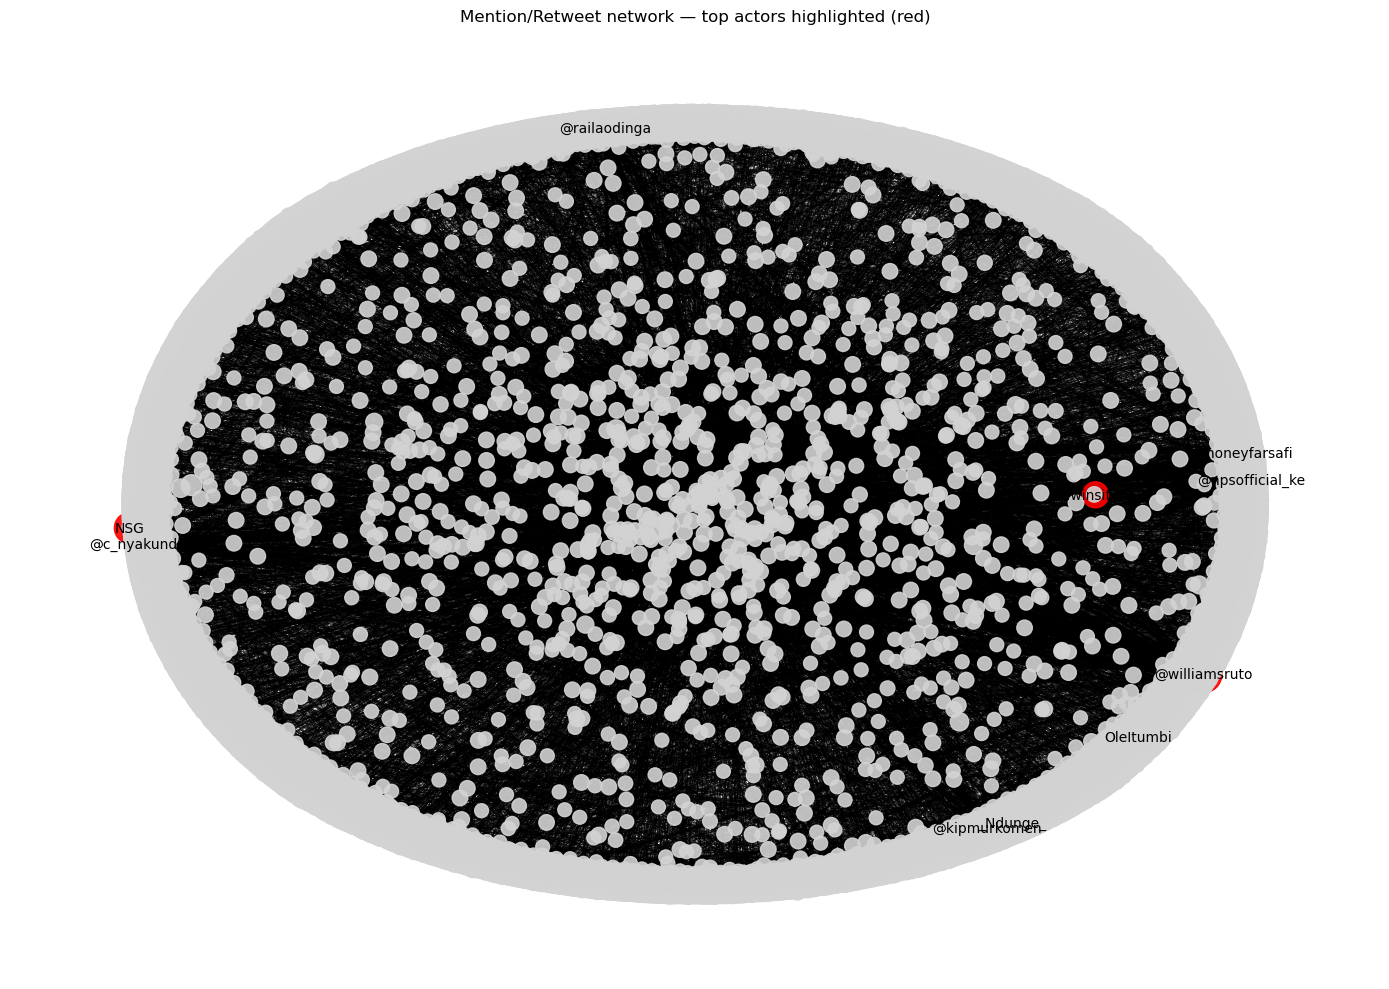

Network plot saved to network_top10.png


In [18]:
# Visualization: highlight top 10 authors in the graph
top_authors = set(top10['author'].tolist())

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.6, iterations=150, seed=42)

# node sizes: scaled by combined score (if node not in met_df, give small size)
score_map = met_df.set_index('author')['combined_score'].to_dict()
node_sizes = [100 + 1000 * score_map.get(n, 0.0) for n in G.nodes()]

# node colors: highlight top authors
node_colors = ['red' if n in top_authors else 'lightgrey' for n in G.nodes()]

# draw
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
# draw top edges thicker: edges between top authors get thicker
edge_widths = [2 if (u in top_authors or v in top_authors) else 0.5 for u,v in G.edges()]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.6)
# labels only for top authors to keep figure readable
labels = {n:n if n in top_authors else '' for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)
plt.title("Mention/Retweet network — top actors highlighted (red)")
plt.axis('off')
plt.tight_layout()
plt.savefig("Influence Network Top 10 - 1.png", dpi=200)
plt.show()
print("Network plot saved to Influence Network Top 10 - 1.png")


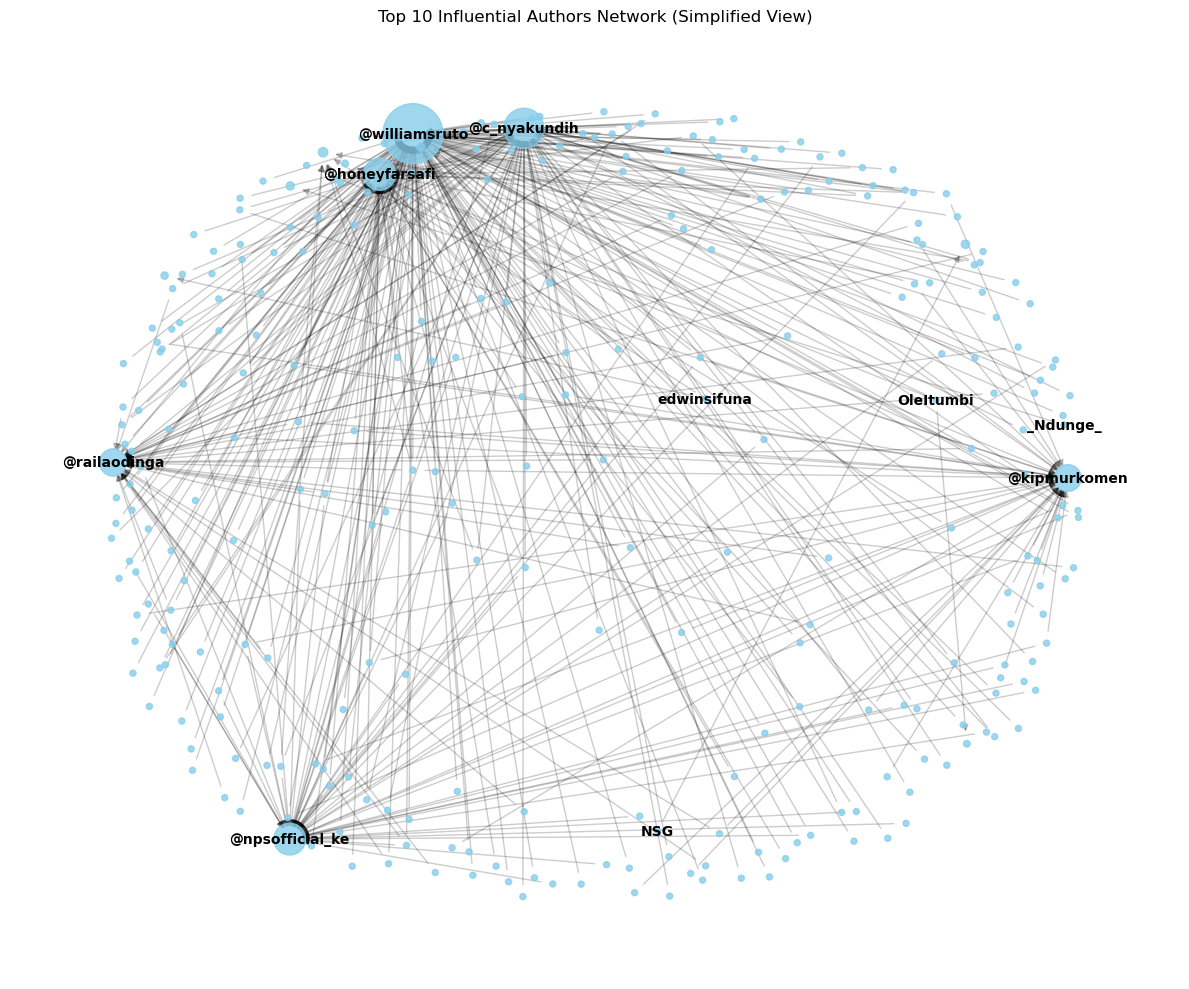

In [13]:
# Optimized layout + subgraph version for large networks
import networkx as nx
import matplotlib.pyplot as plt

# Keep only the top 10 authors and their direct connections
top_nodes = set(top10['author'])
sub_nodes = set()
for u, v in G.edges():
    if u in top_nodes or v in top_nodes:
        sub_nodes.add(u)
        sub_nodes.add(v)

H = G.subgraph(sub_nodes).copy()

# Faster layout computation
pos = nx.spring_layout(H, k=0.8, iterations=40, seed=42)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(H, pos, alpha=0.2)
nx.draw_networkx_nodes(
    H, pos, 
    node_size=[v * 10000 for v in nx.pagerank(H).values()], 
    node_color='skyblue', 
    alpha=0.8
)
nx.draw_networkx_labels(
    H, pos, 
    labels={n: n for n in top_nodes}, 
    font_size=10, 
    font_weight='bold'
)

plt.title("Top 10 Influential Authors Network (Simplified View)")
plt.axis("off")
plt.tight_layout()
plt.savefig("Influence Network Top 10 - 2.png", dpi=300)
plt.show()


# Critical Analysis: Visibility, Platform Dynamics, and Digital Inequalities

### Context
This analysis draws on social media data from the **Kenya Protests 2025** dataset, which includes posts, mentions, and engagement metrics across multiple platforms.  
The dataset provides an opportunity to examine **how visibility, influence, and silence** are produced in digital spaces during a politically charged moment.  
By combining network analysis (using PageRank) with engagement metrics (likes, replies, reposts, impressions), we identify the **top 10 influential actors** who drive visibility and discourse around the protests.

The goal is not only to quantify influence but also to **critically interrogate** how platform dynamics and digital inequalities shape whose voices are amplified and whose are erased.


## 1. Platform Affordances and Amplification
Platform design directly affects whose voices gain visibility.  
Features such as reposting, quoting, and mentioning accelerate attention toward already-central accounts, creating **feedback loops** — those who are visible become even more visible.  

The PageRank measure captures this logic: accounts connected to other highly visible accounts gain structural prestige.  
However, this exposes an inherent bias — **platform affordances reward connectedness, not necessarily significance or truth.**  
Marginalized or dissenting voices may remain on the periphery even when their content resonates deeply within smaller communities.


## 2. Digital Inequalities
Attention and reach are unevenly distributed across digital networks.  
A small subset of users — often verified, institutional, or celebrity accounts — control large followings and dominate engagement flows.  

This structural imbalance skews metrics that rely solely on raw counts of likes, shares, or impressions.  
Normalizing engagement by follower count or impressions can partially correct for this, but such denominators are often missing or unreliable in real-world data.  

Consequently, **grassroots or hyperlocal voices** may appear less influential despite significant community-level impact, reflecting enduring digital inequalities that mirror offline hierarchies of power and access.


## 3. Structural Constraints and Hidden Dynamics
The dataset captures **visible interactions** — mentions, reposts, likes — but not the **invisible infrastructures** that shape information flows:

- Private or encrypted communication (e.g., DMs, WhatsApp groups)  
- Algorithmic moderation, ranking, and shadowbanning  
- Temporal dynamics (posting time, trending cycles)  
- Cross-platform amplification (content reshared by media or influencers elsewhere)  

As a result, we see only what the platform’s design and data access policies make visible.  
**Influence without visibility — or silence produced by moderation or risk — cannot be measured** through engagement or network centrality alone.


## 4. Visibility vs. Silence
Absence from the “top 10” list does not equal insignificance.  
Some actors are **structurally invisible** because they operate in less-connected sub-communities, use local dialects or hashtags, or intentionally avoid engagement-heavy behaviors to reduce exposure.  

Computational visibility must therefore be interpreted as empirical prominence not **moral or social importance  
The *politics of silence* — who is left out, who self-censors, and who is systematically ignored — requires qualitative and contextual inquiry beyond network metrics.


## 5. What the Dataset Cannot Show
Like all digital trace data, this dataset is **partial and platform-dependent**.  
It cannot reveal:

- The **intent** behind engagements (support vs. critique)  
- The **authenticity** of participants (organic users vs. bots or coordinated networks)  
- The **cross-platform narratives** and offline mobilizations that extend beyond social media  

These gaps remind us that quantitative network measures illuminate patterns of attention not the substance of discourse or the quality of influence


## Conclusion
The combined PageRank and engagement approach offers a defensible way to operationalize “influence” and visualize patterns of amplification within the Kenya Protests 2025 dataset.   Yet, it must be interpreted alongside the social, algorithmic, and structural contexts that govern visibility.  

While data science exposes who is most seen and shared, it cannot by itself explain why those patterns emerge, or whose silence sustains them.  
True understanding of influence, exclusion, and power in digital spaces requires an integrated approach — blending computational analysis with critical social insight.
